In [9]:
#  加载数据集
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

和IMDB一样，讲数据限定为前1万个最长出现的单词

In [10]:
print("train_data.length:", len(train_data))
print("test_data.length:", len(test_data))

train_data.length: 8982
test_data.length: 2246


In [11]:
# 将索引解码为新闻文本
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

这一段和上节imdb评论一样

In [12]:
# 编码数据
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# 将数据编码为向量
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [13]:
print("train_label[0]:", train_labels[0])

train_label[0]: 3


In [14]:
# 将标签转换为one-hot向量
def to_one_hot(labels, dimension=46):
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1.
  return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [6]:
print("one_hot_train_labels[0]:", one_hot_train_labels[0])

one_hot_train_labels[0]: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


以上编码的图示：
![img](images/003-006.png)

`to_one_hot`这个方法，keras内置了类似的函数，就是`to_categorical`,上面这段代码可以调整为:

In [15]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [8]:
# 和上面的结果一致
print("one_hot_train_labels[0]:", one_hot_train_labels[0])

one_hot_train_labels[0]: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [16]:
# 构建网络
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

2021-12-13 10:14:21.536378: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


这段代码和之前一样，构建多层网络，只不过增加了Dense层

In [17]:
# 编译模型
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# 看看我们的模型到底是什么
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 46)                2990      
                                                                 
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


In [19]:
# 验证集
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [20]:
history = model.fit(partial_x_train,
                                partial_y_train,
                                epochs=20,
                                batch_size=512,
                                validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 37ms/step - loss: 2.6115 - accuracy: 0.5080 - val_loss: 1.7273 - val_accuracy: 0.6410
Epoch 2/20
16/16 [==============================] - 0s 20ms/step - loss: 1.4176 - accuracy: 0.7136 - val_loss: 1.2835 - val_accuracy: 0.7230
Epoch 3/20
16/16 [==============================] - 0s 21ms/step - loss: 1.0406 - accuracy: 0.7742 - val_loss: 1.1063 - val_accuracy: 0.7500
Epoch 4/20
16/16 [==============================] - 0s 21ms/step - loss: 0.8211 - accuracy: 0.8227 - val_loss: 1.0108 - val_accuracy: 0.7790
Epoch 5/20
16/16 [==============================] - 0s 23ms/step - loss: 0.6542 - accuracy: 0.8641 - val_loss: 0.9395 - val_accuracy: 0.8110
Epoch 6/20
16/16 [==============================] - 0s 20ms/step - loss: 0.5252 - accuracy: 0.8944 - val_loss: 0.9128 - val_accuracy: 0.8040
Epoch 7/20
16/16 [==============================] - 0s 20ms/step - loss: 0.4221 - accuracy: 0.9136 - val_loss: 0.9328 - val_accuracy: 0.7890
Epoch 8/20
16

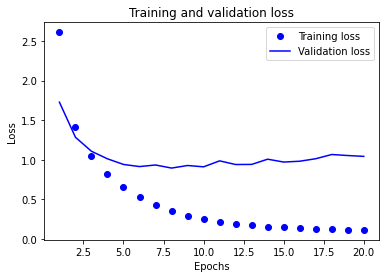

In [21]:
# 绘制训练损失
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

从图示看，epoch为10次的时候，已经足够了，最终训练代码

In [22]:
model.fit(partial_x_train,
                partial_y_train,
                epochs=9,
                batch_size=512,
                validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 33ms/step - loss: 0.1129 - accuracy: 0.9569 - val_loss: 1.0956 - val_accuracy: 0.8020
Epoch 2/9
16/16 [==============================] - 0s 19ms/step - loss: 0.1056 - accuracy: 0.9589 - val_loss: 1.0890 - val_accuracy: 0.7980
Epoch 3/9
16/16 [==============================] - 0s 26ms/step - loss: 0.1070 - accuracy: 0.9568 - val_loss: 1.1390 - val_accuracy: 0.7980
Epoch 4/9
16/16 [==============================] - 0s 22ms/step - loss: 0.1022 - accuracy: 0.9579 - val_loss: 1.1094 - val_accuracy: 0.8010
Epoch 5/9
16/16 [==============================] - 0s 22ms/step - loss: 0.1017 - accuracy: 0.9584 - val_loss: 1.1454 - val_accuracy: 0.7980
Epoch 6/9
16/16 [==============================] - 0s 20ms/step - loss: 0.0990 - accuracy: 0.9572 - val_loss: 1.1668 - val_accuracy: 0.8040
Epoch 7/9
16/16 [==============================] - 0s 24ms/step - loss: 0.1001 - accuracy: 0.9582 - val_loss: 1.2876 - val_accuracy: 0.7830
Epoch 8/9
16/16 [===

In [23]:
results

[1.3776774406433105, 0.7796081900596619]

因为最终输出是46维的，因此中间层的隐藏单元个数不应该比46小太多。如果小于46，会造成信息瓶颈。程序会试图将大量信息压缩到维度很小的中间层，已经不是全部信息了

## 总结
1. 如果要对N个类别进行分类，网络的最后一层应该是大小为N的Dense层
2. 对单标签多分类问题，网络的最后一层使用softmax激活，这样可以输出在N个类别上的概率分布
![img](images/003-007.png)
3. 如果你需要将数据划分到很多类中，应该避免使用太小的中间层，以免在网络中造成信息瓶颈